In [1]:
#Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Load the required packages
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd

In [3]:
#Set some defaults
PATH = "data/DL_Beginner/"
sz=128
#Use resnet34 for a quicker model
arch=resnet101
bs=24

In [4]:
#Training set indices
label_csv = f'{PATH}meta-data/train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
#Number of entries
n

13000

## Initial Exploration

In [6]:
!ls {PATH}

meta-data  models  subm  subm.gz  test	tmp  train


In [7]:
#Get training labels
label_df = pd.read_csv(label_csv)

In [8]:
label_df.head()

,Image_id,Animal
0,Img-1.jpg,hippopotamus
1,Img-2.jpg,squirrel
2,Img-3.jpg,grizzly+bear
3,Img-4.jpg,ox
4,Img-5.jpg,german+shepherd


In [9]:
label_df.pivot_table(index = 'Animal', aggfunc = len).sort_values('Image_id', ascending = False)

,Image_id
Animal,
horse,1111
squirrel,808
antelope,695
german+shepherd,687
collie,680
seal,665
buffalo,606
grizzly+bear,583
otter,519


## Image Exploration

In [10]:
#Build a data model with augmentation
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, folder="train", csv_fname=f"{PATH}meta-data/train.csv", val_idxs=val_idxs,
                                    bs=bs, tfms=tfms, test_name="test")

In [11]:
#Get an image filename
fn = PATH+data.trn_ds.fnames[1]; fn

'data/DL_Beginner/train/Img-100.jpg'

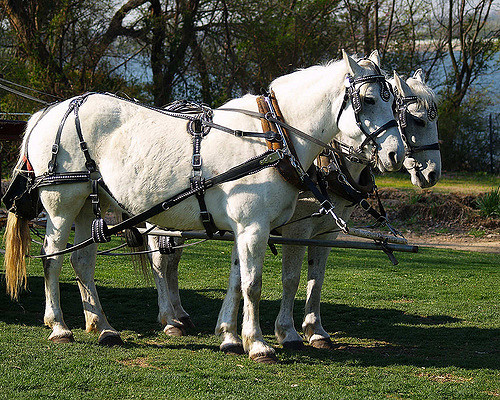

In [12]:
#View the image
img = PIL.Image.open(fn); img 

In [13]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [14]:
row_sz, col_sz = list(zip(*size_d.values()))

(array([ 102., 1158.,  823.,  953., 7324.,    0.,   11.,    1.,    2.,   26.]),
 array([ 165. ,  340.5,  516. ,  691.5,  867. , 1042.5, 1218. , 1393.5, 1569. , 1744.5, 1920. ]),
 <a list of 10 Patch objects>)

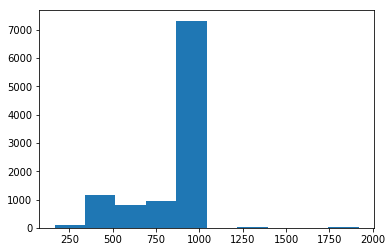

In [15]:
#Get an idea of the image sizes
plt.hist(row_sz)

(array([  83., 1066., 1250., 6278.,  275., 1414.,   15.,    5.,    1.,   13.]),
 array([ 125. ,  304.5,  484. ,  663.5,  843. , 1022.5, 1202. , 1381.5, 1561. , 1740.5, 1920. ]),
 <a list of 10 Patch objects>)

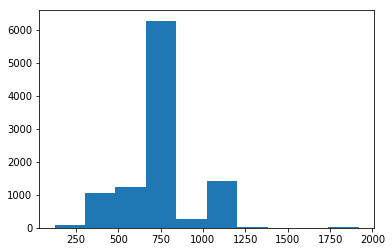

In [16]:
plt.hist(col_sz)

## Create Data Model

In [17]:
#Create a data model where the images are resized and stored in a tmp folder
#This makes resizing quicker 
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_csv(PATH, folder="train", csv_fname=f"{PATH}meta-data/train.csv", val_idxs=val_idxs,
                                    bs=bs, tfms=tfms, test_name="test")
    
    return data if sz > 300 else data.resize(340,'tmp')

In [18]:
#Start with a size of 100
sz = 100

In [19]:
#Get a data model with resized pictures
data = get_data(sz,bs)

## Build Model

In [20]:
#Build a learner with a dropout rate of 0.5
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [21]:
#Find a learning rate
lrf=learn.lr_find()

 81%|████████  | 350/434 [00:39<00:09,  8.96it/s, loss=6.41]

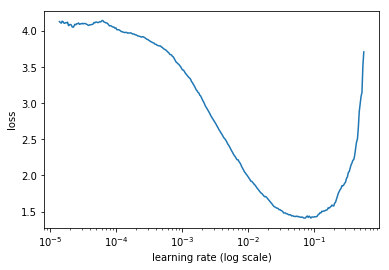

In [22]:
#plot to decided what learning rate to use
learn.sched.plot()

In [23]:
#Train for 4 epochs
learn.fit(1e-2, 4, cycle_len=1, cycle_mult=2)

  0%|          | 1/434 [00:00<01:58,  3.66it/s, loss=4.44]
epoch      trn_loss   val_loss   accuracy                    
    0      0.827908   0.559837   0.83      
    1      0.784708   0.523195   0.841923                    
    2      0.662359   0.505211   0.847692                    
    3      0.705085   0.499815   0.847692                    
    4      0.653615   0.490633   0.848846                    
    5      0.550734   0.472685   0.855769                    
    6      0.585404   0.468444   0.855                       
    7      0.663967   0.513418   0.846538                    
    8      0.649514   0.497115   0.848077                    
    9      0.609659   0.478565   0.852692                    
    10     0.554047   0.475144   0.853462                    
    11     0.483653   0.467924   0.857308                    
    12     0.508278   0.46818    0.853077                    
    13     0.509014   0.468718   0.858077                    
    14     0.478705   0.46827

[array([0.46827]), 0.8576923062251164]

In [24]:
#Unfreeze the last layer
learn.unfreeze()
learn.bn_freeze(True)

In [25]:
#Use differential learning rates
lr=np.array([1e-5,1e-4,1e-2])

In [26]:
#Train for 2 epochs
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.422093   0.441999   0.865769  
    1      0.472368   0.450197   0.862692                    
    2      0.309817   0.411631   0.873846                    



[array([0.41163]), 0.8738461543963506]

In [27]:
#Freeze earlier layers
learn.freeze()

In [28]:
#Save the learner
learn.save('100_hacker_earth')

In [29]:
###### SECOND SIZE ########
#Use a larger size
sz = 224

In [30]:
learn.set_data(get_data(sz,bs))

In [31]:
learn.fit(1e-2, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.172535   0.154459   0.948846  
    1      0.16933    0.1543     0.947692                    
    2      0.154358   0.148542   0.949231                    
    3      0.157348   0.149499   0.949615                    
    4      0.140173   0.145811   0.951154                    
    5      0.14244    0.14311    0.95                        
    6      0.135888   0.143893   0.95                        
    7      0.128154   0.151961   0.949615                    
    8      0.136767   0.147113   0.949231                     
    9      0.105518   0.145624   0.949231                     
    10     0.119236   0.150636   0.948462                     
    11     0.102591   0.148684   0.949231                     
    12     0.080421   0.144951   0.951538                     
    13     0.094759   0.144852   0.951923                     
    14     0.088701   0.145054   0.951538                     



[array([0.14505]), 0.9515384562198932]

In [32]:
learn.unfreeze()

In [33]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.114577   0.149571   0.950769  
    1      0.09499    0.149674   0.950385                     
    2      0.086065   0.13917    0.955385                     



[array([0.13917]), 0.955384610249446]

In [34]:
learn.save('224_hacker_earth')

In [35]:
learn.freeze()

In [36]:
###### THIRD SIZE ########
#Use a larger size
sz = 340

In [37]:
learn.set_data(get_data(sz,bs))

In [38]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.097771   0.106339   0.963846  
    1      0.098041   0.112035   0.961538                     
    2      0.081807   0.105896   0.964615                     
    3      0.104143   0.117365   0.964231                     
    4      0.088069   0.106075   0.962308                     
    5      0.066752   0.105048   0.964615                     
    6      0.059069   0.104266   0.964615                     



[array([0.10427]), 0.9646153816810021]

In [ ]:
#Train the previous layers with a larger image size only if you have enough memory. Can cause your kernel to crash due to memeory issues
#Skip straight to the prediction section if you have memory issues

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.freeze()

In [39]:
learn.save('340_hacker_earth')

## Prediction

In [40]:
#Get predictions with test time augmentation - TTA prodcues 2 array outputs
log_preds, y = learn.TTA(is_test = True)

In [41]:
#get the exponent - TTA
probs = np.mean(np.exp(log_preds),0)

In [42]:
#Create data frame
ds = pd.DataFrame(probs)

In [43]:
#Add column names
ds.columns = data.classes

In [44]:
#View the first test image
#Get an image
fn = PATH+data.test_ds.fnames[1]; fn

'data/DL_Beginner/test/Img-2166.jpg'

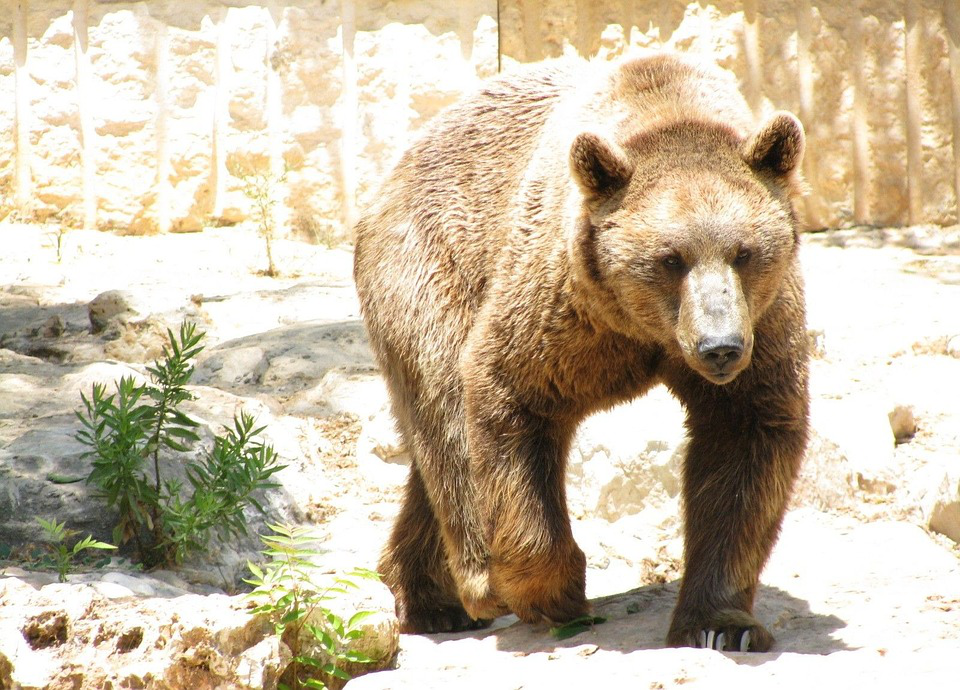

In [45]:
img = PIL.Image.open(fn); img 

In [46]:
#Insert IDs, but remove folder name
ds.insert(0,'image_id', [o[5:-4] + '.jpg' for o in data.test_ds.fnames])

In [47]:
#Check the df
ds.shape

(6000, 31)

In [48]:
#Get the test data set ids
test_label_csv = f'{PATH}meta-data/test.csv'
#Get test labels
test_label_df = pd.read_csv(test_label_csv)

In [49]:
ds = ds.set_index('image_id')
ds = ds.reindex(index=test_label_df['Image_id'])
ds = ds.reset_index()

In [50]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok = True)
ds.to_csv(f'{PATH}subm/subm.csv', index = False)

In [ ]:
#Create file link to download csv
FileLink(f'{SUBM}subm.csv')